# DOCUMENTATION

1. Import relevant libraries
2. Set current directory as the working directory
2. Obtain the details for retrieving and storing the data
3. Get the dataset from mongoDB database and store it as a pandas dataframe. <br/>
4. Reduce the orginial dataframe by removing the columns which are not needed for Topic Modelling. Currently we are considering only the area and the description of the project as the columns in our dataframe. 
5. Load the stopwords and the stemmer
6. Tokenize and Stem the description data present in the dataframe.
7. Generate bigrams from the tokenized and stemmed data (keep threshold very low)
8. Remove the samples which have less than 10 tokens from further analysis
9. Split the original dataset into training and test dataset
10. Generate a LDA model on the training dataset

### Importing all the relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from nltk.tokenize import word_tokenize
import pickle
import string
from string import punctuation
import os
%matplotlib inline
sns.set_style("darkgrid")

### Set the current directory where this notebook is present as working Directory

In [2]:
currDir = os.getcwd()
if "USL" not in currDir:
    os.chdir(os.path.join(currDir,  "ML", "USL"))
print("Current directory is: " + currDir)

Current directory is: /opt/jupyter/Icxa/projectfinder_analytics/ML/USL


### Database details for retrieving dataset and storing the dataset

In [3]:
#Details for retrieving  data from projectfinder
db_loc = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'database' : 'projectfinder',
    'collection' : 'itproject_clean'
}

In [4]:
#Details for storing data related to projectfinder
db_data = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'database' : 'projectfinder',
    'collection' : 'mldata1'
}

#%%[markdown]
#Methods for loading the dataset

### Load the dataset from MongoDB as a pandas dataframe 

In [5]:
from script_files import load_save_dataset as load_save_DS
df_raw = load_save_DS.load_dataset_from_mongodb(db_loc)
df_raw.shape

Data loaded from mongodb itproject_clean collection succesfully


(14059, 25)

### Reduce raw dataset to columns relevant for analysis

In [6]:
def get_required_dataset(original_dataset):
    
    #Select required colunms
    df = original_dataset[['description', 'bereich']]
    
    #Remove the rows which have no information in the description field/column
    df = df[df['description'] != '']
    
    #Rename the columns
    df = df.rename(columns = {"description" : "project", "bereich" : "label"})
    
    #Remove rows containing labels with very low frequency
    df = df[df['label'] != 'IT/Bauingenieur']
    
    #Remove duplicates
    df = df.drop_duplicates()
    
    #Shuffle the dataset
    df = df.sample(frac=1.0)
    df.reset_index(drop=True,inplace=True)
    
    return df

In [7]:
df_preprocessed = get_required_dataset(df_raw)
df_preprocessed.shape
df_preprocessed.head()

,project,label
0,Projektbeschreibung \n\n ...,Dev-Web-Backend
1,Aufgabe: \n* Leitung von Investitions- und Opt...,IT/Mess- / Rege
2,Projektbeschreibung \n\n ...,IT-Security
3,Als Weltmarktführer für Qualität stehen wir se...,IT/Konstruktion
4,Projektbeschreibung \n\n ...,Data-Sci-BI


In [8]:
df_preprocessed.iloc[0,0]

'Projektbeschreibung \n\n                             \n              Melden Sie sich jetzt an und bewerben Sie sich direkt! \n              Jetzt bewerben \n         \n    \n\n                                Wir sind aktuell auf der Suche nach Unterstützung für unseren Kunden. Einsatzort: Hamburg oder Berlin, ggf. remote möglich Start: asap, Laufzeit 1-2 Jahre.  Es soll eine (Java) Applikationslandschaft auf einen halbwegs aktuellen Stand zmigriert werden (Maven, Git, Spring) und die bestehende Lösung zu vereinfachen. REST, Web, Cloud usw. spielt keine große Rolle. Perspektivisch wird es auch darum gehen die bestehenden Server in Docker Containern zu betreiben. Das ist aber eher mittel bis langfristig. Die Landschaft selbst besteht aus verschiedenen Komponenten, überwiegend selbstgeschriebene Java Lösungen, die auf Spring aufsetzen. Es handelt sich um klassische 3 Schichten Architekturen, mit Rich-Clients. Die Server werden in TomCats gehostet. Es wäre wichtig, dass es sich um jemande

### Loading stopwords and stemmer 

In [9]:
dataDir = os.path.join(currDir,  "constants")
stopwordsLocation = os.path.join(dataDir, "stopwords.pickle")
pickle_in = open(stopwordsLocation,"rb")
stopwords_all = pickle.load(pickle_in)

In [10]:
print(len(stopwords_all))

13242


In [11]:
stemmerLocation = os.path.join(dataDir, "stemmer_own.pickle")
pickle_in = open(stemmerLocation,"rb")
stemmer_own = pickle.load(pickle_in)

### Perform tokenization, stemming on the text

In [12]:
def text_processing(text):
    """Normalize, tokenize, stem the original text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    cleaned: list of strings. List containing normalized and stemmed word tokens with bigrams
    """

    try:
        text = re.sub(r'(\d)',' ',text.lower())
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        tokens = word_tokenize(text)
        tokens_cleaned = [word for word in tokens if word not in stopwords_all and len(word) > 1]
        
        stemmed_tokens = []
        stemmer_keys = list(stemmer_own.keys())
        for word in tokens_cleaned:
            for stemmer_key in stemmer_keys:
                if stemmer_key in word:
                    stemmed_word = stemmer_own[stemmer_key]
                    stemmed_tokens.append(stemmed_word)
                    break
            else:
                stemmed_tokens.append(word)
  
                

    except IndexError:
        pass

    return stemmed_tokens

In [13]:
# Clean text and title and create new column "tokenized"
t1 = time.time()
df_preprocessed['token_stem_spRm'] = df_preprocessed['project'].apply(text_processing)
t2 = time.time()

In [14]:
print("Time taken to prepare", len(df_preprocessed), "projects documents:", (t2-t1)/60, "min")

Time taken to prepare 12168 projects documents: 7.387639574209849 min


In [15]:
df_preprocessed.head()

,project,label,token_stem_spRm
0,Projektbeschreibung \n\n ...,Dev-Web-Backend,"[java, application, halbwegs, stand, zmigriert..."
1,Aufgabe: \n* Leitung von Investitions- und Opt...,IT/Mess- / Rege,"[leitung, investitions, optimierungsprojekten,..."
2,Projektbeschreibung \n\n ...,IT-Security,"[cyber, security, berater, successful, entwick..."
3,Als Weltmarktführer für Qualität stehen wir se...,IT/Konstruktion,"[weltmarktführer, qualität, inspektionen, veri..."
4,Projektbeschreibung \n\n ...,Data-Sci-BI,"[zunehmend, tech, support, harvey, nash, deuts..."


### Make bigrams

In [16]:
bigram = gensim.models.Phrases(df_preprocessed['token_stem_spRm'].tolist(), min_count=2, threshold=2) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(text):
    return bigram_mod[text]

In [17]:
df_preprocessed['token_stem_spRm_bigram'] = df_preprocessed['token_stem_spRm'].apply(make_bigrams)

In [18]:
df_preprocessed.head()

,project,label,token_stem_spRm,token_stem_spRm_bigram
0,Projektbeschreibung \n\n ...,Dev-Web-Backend,"[java, application, halbwegs, stand, zmigriert...","[java, application, halbwegs, stand, zmigriert..."
1,Aufgabe: \n* Leitung von Investitions- und Opt...,IT/Mess- / Rege,"[leitung, investitions, optimierungsprojekten,...","[leitung, investitions, optimierungsprojekten,..."
2,Projektbeschreibung \n\n ...,IT-Security,"[cyber, security, berater, successful, entwick...","[cyber_security, berater_successful, entwicklu..."
3,Als Weltmarktführer für Qualität stehen wir se...,IT/Konstruktion,"[weltmarktführer, qualität, inspektionen, veri...","[weltmarktführer, qualität, inspektionen, veri..."
4,Projektbeschreibung \n\n ...,Data-Sci-BI,"[zunehmend, tech, support, harvey, nash, deuts...","[zunehmend_tech, support_harvey, nash_deutschl..."


In [19]:
df_preprocessed.iloc[2,3]

['cyber_security',
 'berater_successful',
 'entwicklung',
 'deliver',
 'key',
 'components',
 'isms',
 'areas',
 'risk_assessment',
 'method',
 'risk',
 'treatment',
 'plans',
 'statement',
 'application',
 'initial',
 'immediate',
 'evidence',
 'significant',
 'deep',
 'security',
 'security',
 'disciplines',
 'leadership',
 'risk_assessment',
 'risk_management',
 'iso_iec',
 'proven',
 'tracked',
 'record',
 'providing',
 'security',
 'documentation',
 'transparent',
 'collaborative',
 'making',
 'decisions',
 'ideal',
 'possibility',
 'initial_period',
 'weeks',
 'ideally',
 'interpersonal',
 'ambitious',
 'enjoy',
 'solving_complex',
 'security',
 'problems',
 'directly']

In [20]:
outputDir = os.path.join(currDir,  "output", "Approach_2")
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

In [21]:
df_prepro_Loc = os.path.join(outputDir,  "df_preprocessed.pickle")
pickle_out = open(df_prepro_Loc,"wb")
pickle.dump(df_preprocessed, pickle_out)
pickle_out.close()

In [22]:
df_preprocessed.head(20)

,project,label,token_stem_spRm,token_stem_spRm_bigram
0,Projektbeschreibung \n\n ...,Dev-Web-Backend,"[java, application, halbwegs, stand, zmigriert...","[java, application, halbwegs, stand, zmigriert..."
1,Aufgabe: \n* Leitung von Investitions- und Opt...,IT/Mess- / Rege,"[leitung, investitions, optimierungsprojekten,...","[leitung, investitions, optimierungsprojekten,..."
2,Projektbeschreibung \n\n ...,IT-Security,"[cyber, security, berater, successful, entwick...","[cyber_security, berater_successful, entwicklu..."
3,Als Weltmarktführer für Qualität stehen wir se...,IT/Konstruktion,"[weltmarktführer, qualität, inspektionen, veri...","[weltmarktführer, qualität, inspektionen, veri..."
4,Projektbeschreibung \n\n ...,Data-Sci-BI,"[zunehmend, tech, support, harvey, nash, deuts...","[zunehmend_tech, support_harvey, nash_deutschl..."
5,Aktuell sind wir für unseren Endkunden auf der...,IT-Mgmt-Consulting,"[coventry, offsite, sprachanforderung, account...","[coventry_offsite, sprachanforderung_accountab..."
6,Gesamtprojektleiter Steuergerätentwicklung (M/...,IT-Mgmt-Projectleiter,"[gesamtprojektleiter, entwicklung, –norddeutsc...","[gesamtprojektleiter, entwicklung, –norddeutsc..."
7,- Visualisierung mit Wonderware InTouch \n- Vi...,IT/,"[visualisierung, wonderware, intouch, visualis...","[visualisierung, wonderware_intouch, visualisi..."
8,Your tasks - You plan and develop a variety of...,Dev-Web-Fullstack,"[plan, entwicklung, variety, application, back...","[plan, entwicklung, variety, application, back..."
9,Projektbeschreibung \n\n ...,IT-Mgmt-Projectleiter,"[kundenprojekt, leiter, test, center, eigenver...","[kundenprojekt, leiter_test, center, eigenvera..."


In [23]:
# only keep articles with more than 10 tokens, otherwise too short
df_preprocessed = df_preprocessed[df_preprocessed['token_stem_spRm_bigram'].map(len) >= 10]
# make sure all tokenized items are lists
df_preprocessed = df_preprocessed[df_preprocessed['token_stem_spRm_bigram'].map(type) == list]
df_preprocessed.reset_index(drop=True,inplace=True)

In [24]:
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_preprocessed), "articles")

After cleaning and excluding short aticles, the dataframe now has: 11759 articles


### Split data to training and testing 

In [25]:
# create a mask of binary values to split into train and test
msk = np.random.rand(len(df_preprocessed)) < 0.9960
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
train_df = df_preprocessed[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df_preprocessed[~msk]
test_df.reset_index(drop=True,inplace=True)

In [27]:
train_df.head()

,project,label,token_stem_spRm,token_stem_spRm_bigram
0,Projektbeschreibung \n\n ...,Dev-Web-Backend,"[java, application, halbwegs, stand, zmigriert...","[java, application, halbwegs, stand, zmigriert..."
1,Aufgabe: \n* Leitung von Investitions- und Opt...,IT/Mess- / Rege,"[leitung, investitions, optimierungsprojekten,...","[leitung, investitions, optimierungsprojekten,..."
2,Projektbeschreibung \n\n ...,IT-Security,"[cyber, security, berater, successful, entwick...","[cyber_security, berater_successful, entwicklu..."
3,Als Weltmarktführer für Qualität stehen wir se...,IT/Konstruktion,"[weltmarktführer, qualität, inspektionen, veri...","[weltmarktführer, qualität, inspektionen, veri..."
4,Projektbeschreibung \n\n ...,Data-Sci-BI,"[zunehmend, tech, support, harvey, nash, deuts...","[zunehmend_tech, support_harvey, nash_deutschl..."


### Train the LDA model on training data

In [28]:
def train_lda(data, n=10):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = n
    chunksize = 300
    dictionary = corpora.Dictionary(data['token_stem_spRm_bigram'])
    corpus = [dictionary.doc2bow(doc) for doc in data['token_stem_spRm_bigram']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df_preprocessed), "documents: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [29]:
dictionary,corpus,lda = train_lda(train_df, 10)

Time to train LDA model on  11759 documents:  0.7405274391174317 min


In [30]:
filename = os.path.join(outputDir, 'LDA_Approach_2.model')
lda.save(filename)

In [31]:
from gensim import corpora, models, similarities
model =  models.LdaModel.load(filename)

In [32]:
# print all topics
model.show_topics(num_topics=20, num_words=20)

[(0,
  '0.051*"verfügen" + 0.035*"firewall" + 0.031*"mm" + 0.028*"sw" + 0.027*"engineer_tech" + 0.023*"sap_mm" + 0.022*"iso" + 0.022*"tech" + 0.019*"reisebereitschaft" + 0.018*"maschinen" + 0.016*"engineer" + 0.014*"starker_engineer" + 0.014*"engineer_personalmarktes" + 0.013*"analyst_design" + 0.013*"projekt" + 0.013*"android" + 0.010*"qm" + 0.010*"sap_pm" + 0.010*"tomcat" + 0.010*"außerdem"'),
 (1,
  '0.027*"vorhandener" + 0.016*"konstruktion" + 0.013*"training" + 0.012*"senior_java" + 0.012*"banking" + 0.011*"cases" + 0.011*"gemeinsam" + 0.011*"docker_kubernetes" + 0.011*"soa" + 0.010*"status" + 0.010*"eplan" + 0.010*"fortgeschrittene" + 0.010*"create" + 0.009*"provider" + 0.009*"zuverlässigkeit" + 0.009*"configuration" + 0.009*"java_enterprise" + 0.009*"pmo" + 0.009*"site" + 0.009*"vertrieb"'),
 (2,
  '0.087*"management" + 0.049*"system" + 0.039*"sap" + 0.037*"tech" + 0.036*"process" + 0.035*"entwicklung" + 0.032*"analyst" + 0.030*"berater" + 0.027*"operation" + 0.025*"application"

In [33]:
with open(os.path.join(outputDir, 'dictionary_LDA_A2'), 'wb') as output:
    pickle.dump(dictionary, output)
    
with open(os.path.join(outputDir, 'corpus_LDA_A2'), 'wb') as output:
    pickle.dump(corpus, output)

In [34]:
# Save model to disk.
from gensim.test.utils import datapath
temp_file = datapath('LDA_Approach_2.model')
lda.save(temp_file)
pickle.dump(lda, open(os.path.join(outputDir, 'model_LDA_A2'), 'wb'))

In [35]:
# Load a potentially pretrained model from disk.
lda2 = LdaModel.load(temp_file)

In [36]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=13, num_words=20)

[(0,
  '0.051*"verfügen" + 0.035*"firewall" + 0.031*"mm" + 0.028*"sw" + 0.027*"engineer_tech" + 0.023*"sap_mm" + 0.022*"iso" + 0.022*"tech" + 0.019*"reisebereitschaft" + 0.018*"maschinen" + 0.016*"engineer" + 0.014*"starker_engineer" + 0.014*"engineer_personalmarktes" + 0.013*"analyst_design" + 0.013*"projekt" + 0.013*"android" + 0.010*"qm" + 0.010*"sap_pm" + 0.010*"tomcat" + 0.010*"außerdem"'),
 (1,
  '0.027*"vorhandener" + 0.016*"konstruktion" + 0.013*"training" + 0.012*"senior_java" + 0.012*"banking" + 0.011*"cases" + 0.011*"gemeinsam" + 0.011*"docker_kubernetes" + 0.011*"soa" + 0.010*"status" + 0.010*"eplan" + 0.010*"fortgeschrittene" + 0.010*"create" + 0.009*"provider" + 0.009*"zuverlässigkeit" + 0.009*"configuration" + 0.009*"java_enterprise" + 0.009*"pmo" + 0.009*"site" + 0.009*"vertrieb"'),
 (2,
  '0.087*"management" + 0.049*"system" + 0.039*"sap" + 0.037*"tech" + 0.036*"process" + 0.035*"entwicklung" + 0.032*"analyst" + 0.030*"berater" + 0.027*"operation" + 0.025*"application"

In [37]:
for t_id in range (2):
    print("TopicID: " + str(t_id))
    topics = lda.show_topic(topicid=t_id, topn=20)
    for topic in topics:
        print(topic[0] + ": " + str(topic[1]))
    print()


TopicID: 0
verfügen: 0.050789494
firewall: 0.03490141
mm: 0.030893894
sw: 0.028053312
engineer_tech: 0.026665838
sap_mm: 0.02341528
iso: 0.022346226
tech: 0.021663735
reisebereitschaft: 0.018512323
maschinen: 0.01811735
engineer: 0.015961273
starker_engineer: 0.013784124
engineer_personalmarktes: 0.013784124
analyst_design: 0.013331694
projekt: 0.013071149
android: 0.012724849
qm: 0.0104388
sap_pm: 0.010215576
tomcat: 0.010144164
außerdem: 0.009840365

TopicID: 1
vorhandener: 0.026557166
konstruktion: 0.016085109
training: 0.0128923915
senior_java: 0.012065059
banking: 0.01172006
cases: 0.011277564
gemeinsam: 0.011123645
docker_kubernetes: 0.010894062
soa: 0.010522562
status: 0.010355399
eplan: 0.010283411
fortgeschrittene: 0.010165812
create: 0.009981651
provider: 0.009145095
zuverlässigkeit: 0.009091344
configuration: 0.009064241
java_enterprise: 0.0088617345
pmo: 0.008698048
site: 0.008637747
vertrieb: 0.008604425



### Random project from training data

In [38]:
#Select an article at random from train_df
random_index = int(np.random.randint(len(train_df), size=[1, 1]))
print(random_index)

6468


In [39]:
data_to_check = train_df.iloc[random_index,2]
bow = dictionary.doc2bow(data_to_check)
doc_distribution = np.array([topic[1] for topic in lda.get_document_topics(bow=bow)])

In [40]:
print(train_df.iloc[random_index,2])

['efk', 'inhabergeführter', 'dienstleister', 'stamm', 'festangestellten', 'umfangreichen', 'gepflegten', 'pool', 'freelancern', 'begleiten', 'konzerne', 'kmu', 'bedarfsfall', 'weltbekannte', 'schiffswerft', 'temporären', 'projektunterstützung', 'php', 'entwicklung', 'tech', 'stack', 'fühlt', 'php', 'symfony', 'sql', 'oracle', 'html', 'script', 'css', 'script', 'framework', 'ext', 'js', 'rabbitmq', 'message', 'brocker', 'docker', 'git', 'branching', 'modell', 'linux', 'serverebene', 'erstreckt', 'planung', 'entwicklung', 'wartung', 'internal', 'software', 'firmengruppe', 'entwicklung', 'erp', 'system', 'portal', 'köpfigen', 'application', 'management', 'innovative', 'blicke', 'reling', 'hinaus', 'herzlich', 'willkommen', 'einarbeitung', 'arbeit', 'evtl', 'einsatzbeginn', 'einsatzende', 'projekt', 'unterstützen', 'projektübersicht', 'nk', 'remotestundensatz']


In [41]:
print(doc_distribution)
print(len(doc_distribution))
np.argsort(-doc_distribution)[:3]
print(doc_distribution)
print(len(doc_distribution))

[2.6962502e-04 2.6962502e-04 2.8135490e-01 2.6962502e-04 6.1700916e-01
 5.0019369e-02 2.6962502e-04 4.9998824e-02 2.6962502e-04 2.6962502e-04]
10
[2.6962502e-04 2.6962502e-04 2.8135490e-01 2.6962502e-04 6.1700916e-01
 5.0019369e-02 2.6962502e-04 4.9998824e-02 2.6962502e-04 2.6962502e-04]
10


In [42]:
# bar plot of topic distribution for this document
def plot_topic_dist(doc_distr, index):
    """
    This function plots the topic distrubtion for a given document
    It takes two parameters
    (1) doc_distr = type: list of floats, list of topic probability distribution in a document
    (2) index = type: int, index number of document to plot
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    fig, ax = plt.subplots(figsize=(12,8));
    # the histogram of the data
    patches = ax.bar(np.arange(len(doc_distr)), doc_distr)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Probability Score', fontsize=15)
    ax.set_title("Topic Distribution for Project in Index " + str(index), fontsize=20)
    ax.set_xticks(range(0,10))
    x_ticks_labels = ['ERP/SAP','SW_Dev/Web','IT_App_Mgr/SW_Dev_Arch','SW_Dev/DevOps','Sys_Admin/Support', 'IT_Admin_SW/Oracle/Ops','Data/Ops','IT_Process_Mgr/Consultant', 'MS_DEV/Admin','Business_Analyst/Consulting']
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=8)
    fig.tight_layout()
    return plt.show()

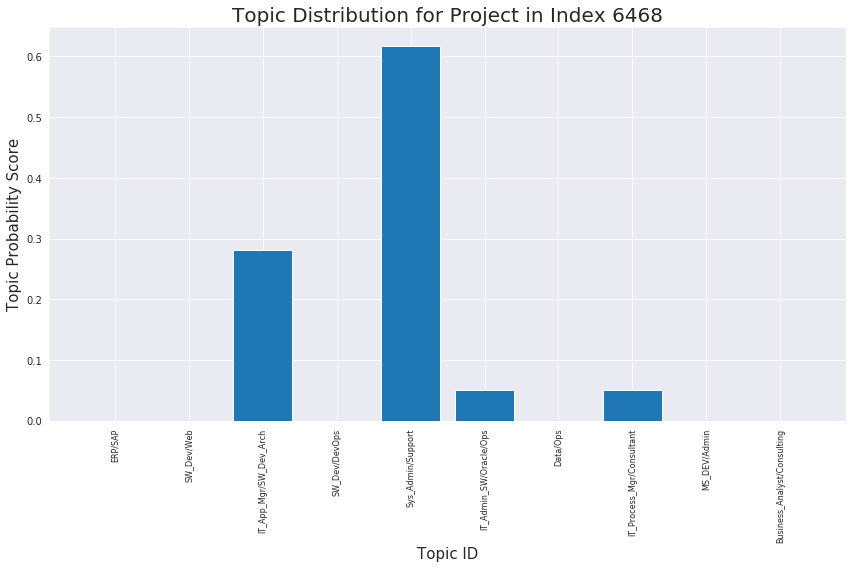

In [43]:
plot_topic_dist(doc_distribution, random_index)